# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number :

## Student 1 
### Name :
### ID :

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [222]:
import numpy as np
import pandas as pd 

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style('grade3')

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [2]:
# load the data
training_data = pd.read_csv('./SWaT_train.csv')
testing_data = pd.read_csv('./SWaT_test.csv')

training_signals = training_data.drop(columns=[' Timestamp', 'Normal/Attack'])
training_label = training_data['Normal/Attack']
training_label = np.where(training_label.to_numpy() == 'Normal', 0, 1)

testing_signals = testing_data.drop(columns=['Unnamed: 0', ' Timestamp', 'Normal/Attack'])
testing_label = testing_data['Normal/Attack']
testing_label = np.where(testing_label.to_numpy() == 'Normal', 0, 1)

training_data.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


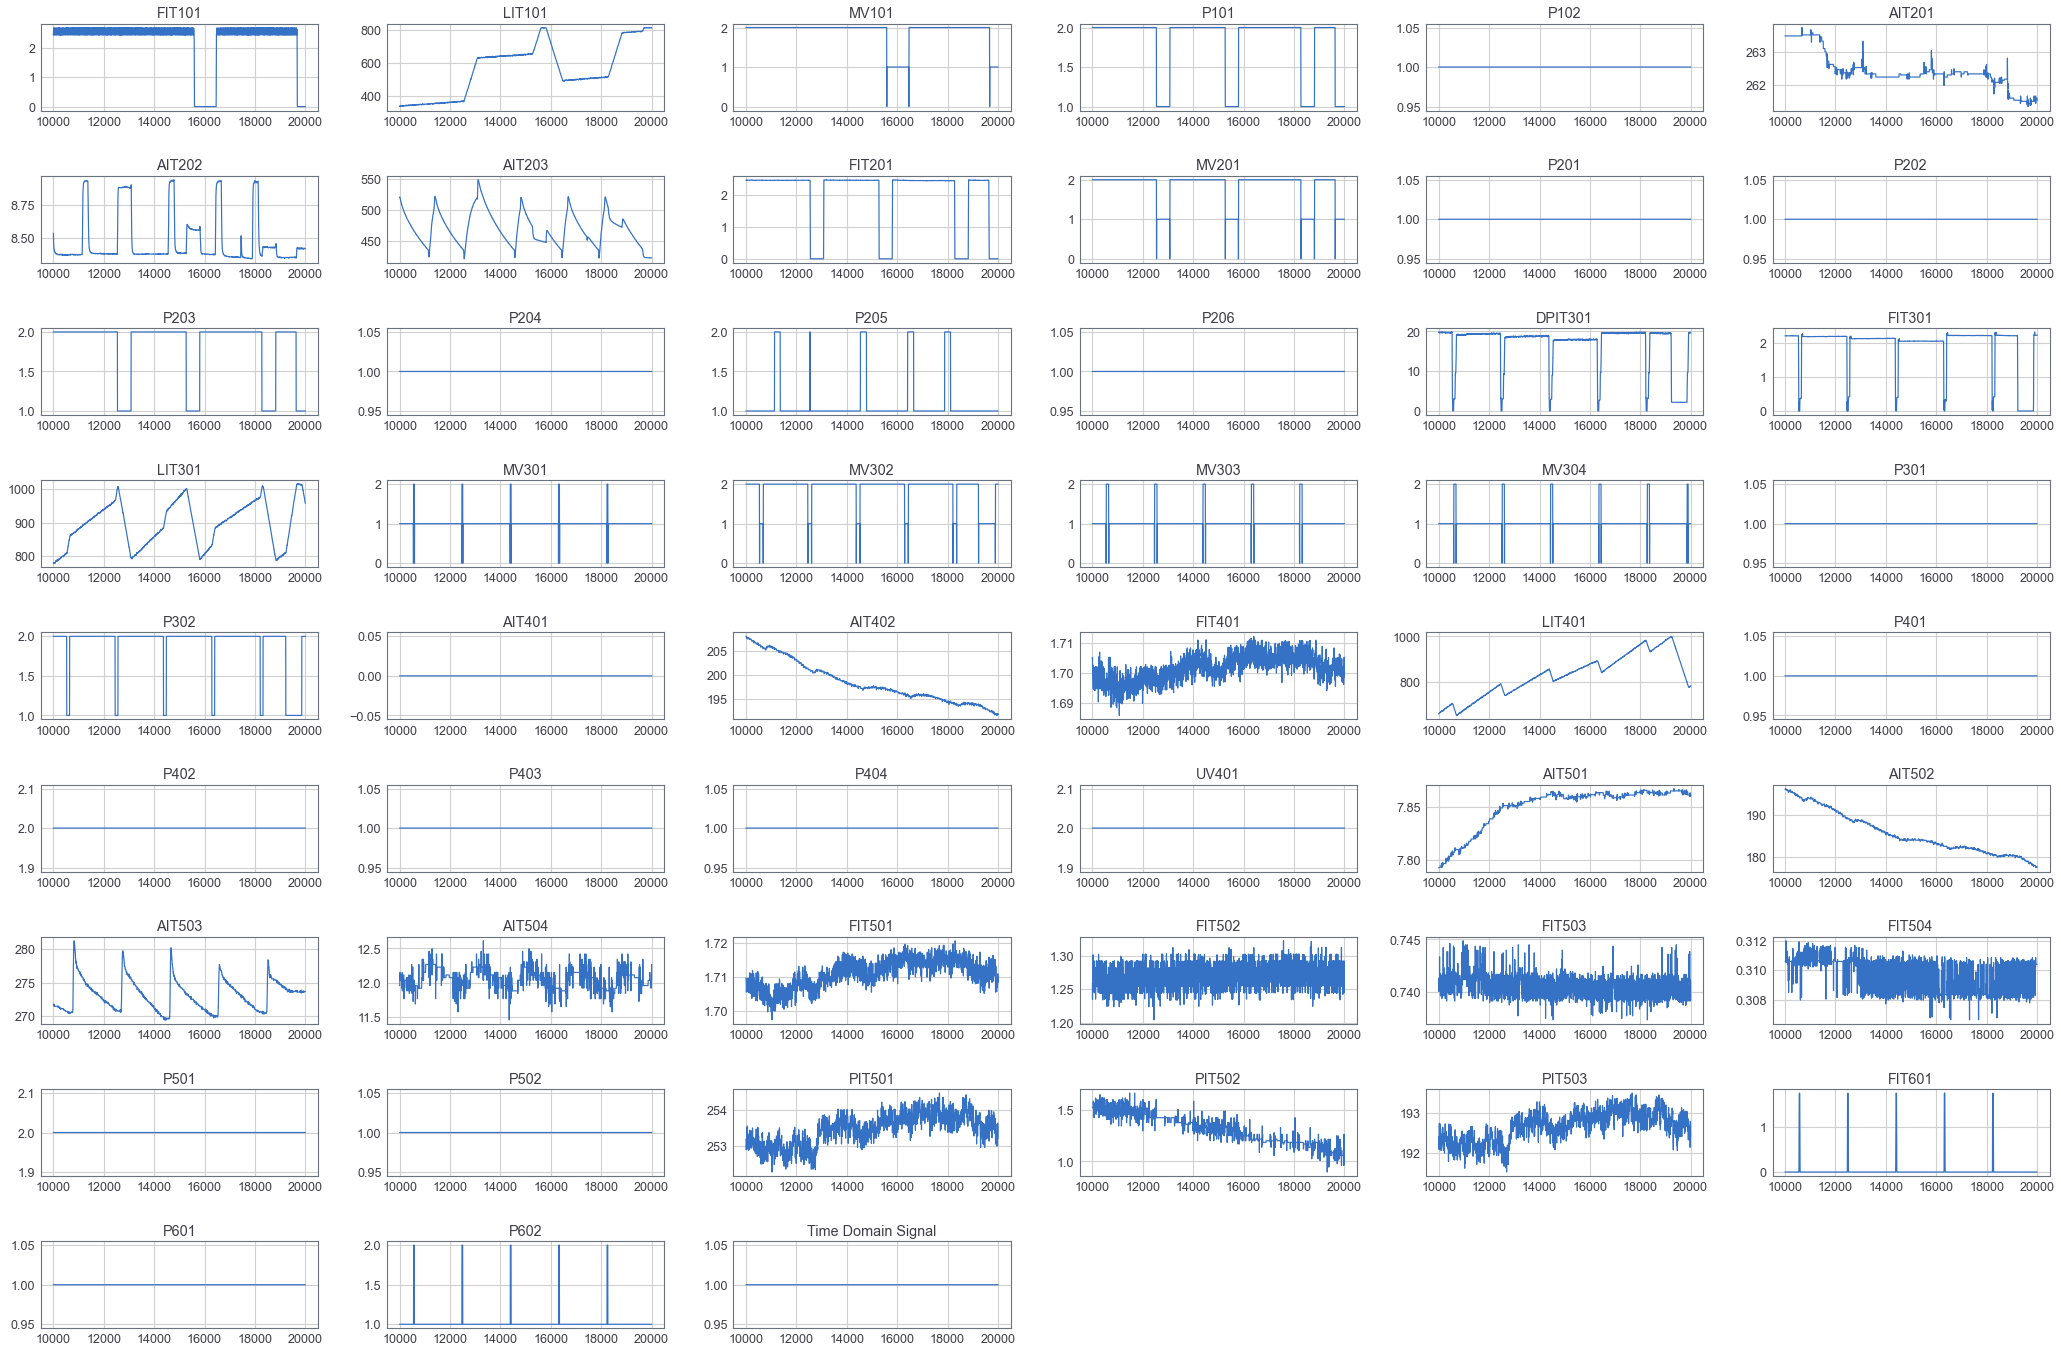

In [3]:
# to visualize patrial data
i = 1
plt.figure(figsize=(36, 24))
plt.subplots_adjust(wspace=0.25, hspace=0.75)
for col in list(training_signals.columns):
    plt.subplot(9, 6, i)
    training_signals.loc[10000:20000, col].plot()
    plt.title(col)
    i += 1
plt.title("Time Domain Signal")
plt.show()

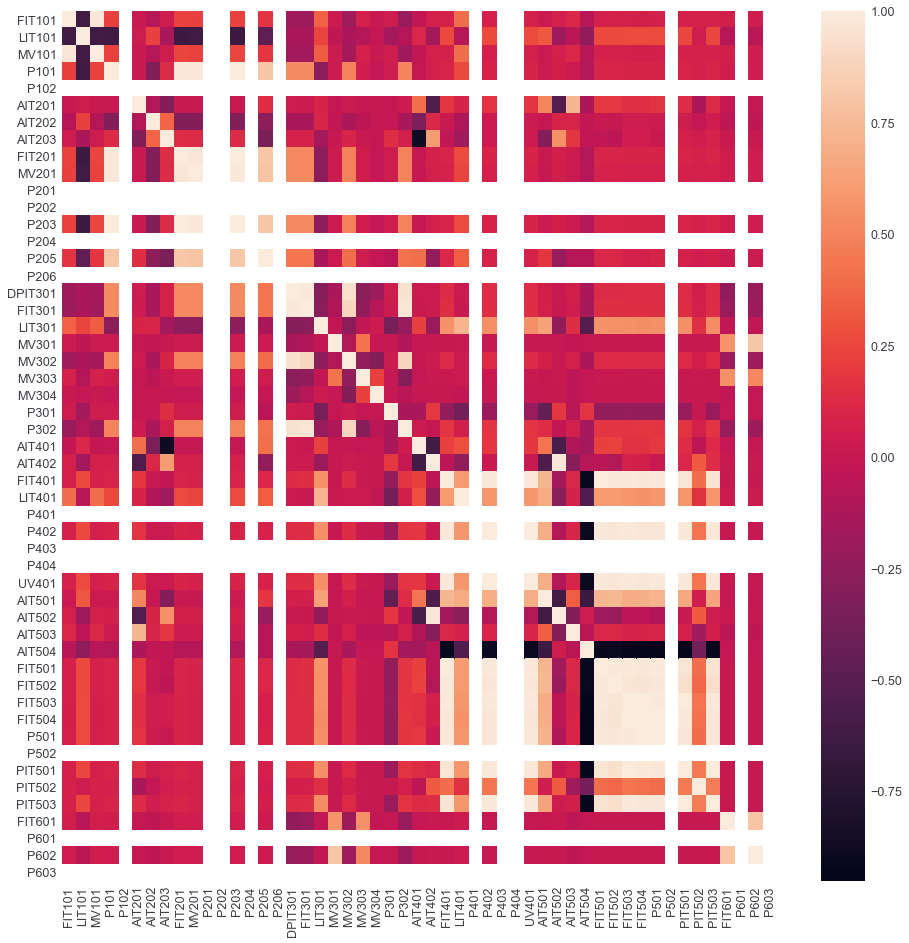

In [4]:
# to plot correlation matrix
corr = training_signals.corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, xticklabels=list(corr.columns), yticklabels=list(corr.columns))
plt.show()

In [245]:
# sliding_window for the forcast
def sliding_window(df, window_size, stride=1):
    N = np.floor((len(df) - window_size)/stride).astype(np.int)+1
    return_window = []
    for i in range(N):
        return_window.append(df[i*stride:i*stride+window_size])
    return np.array(return_window)

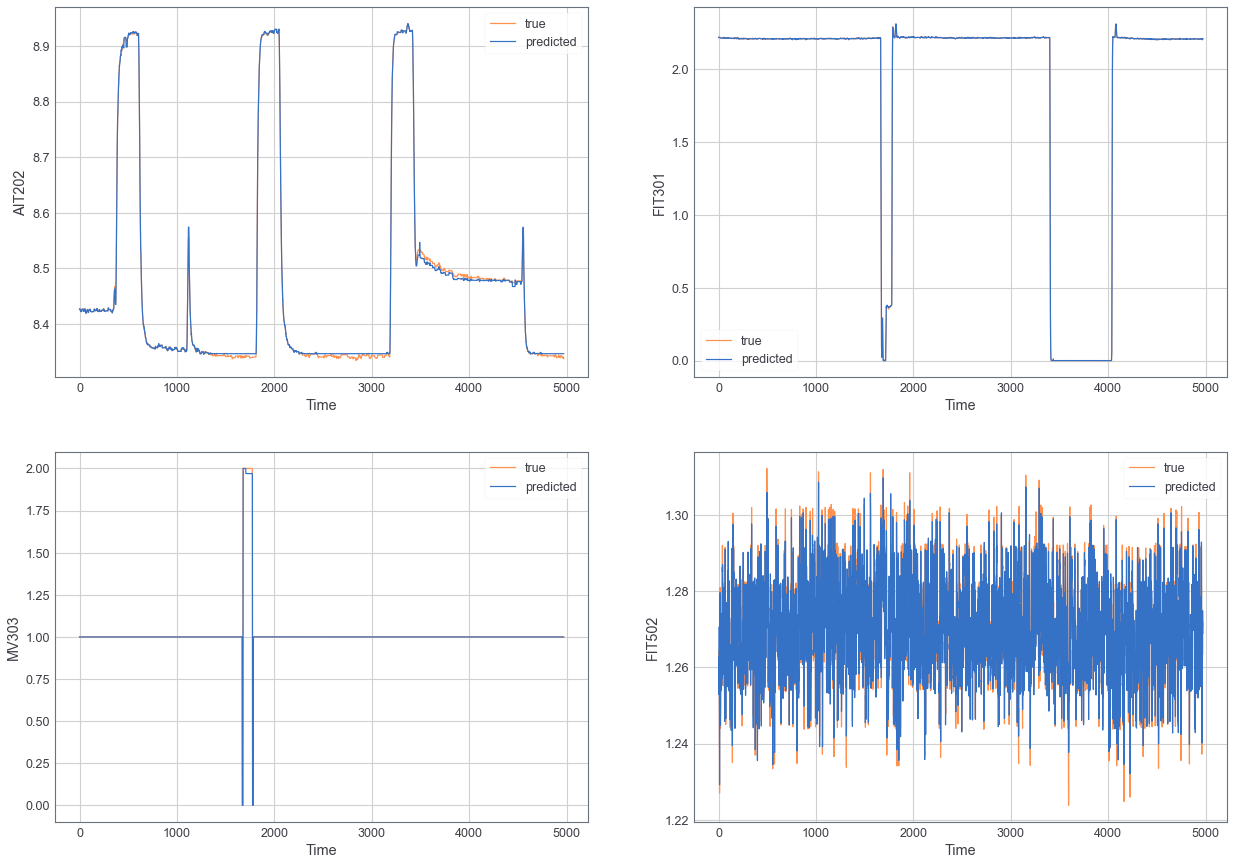

In [6]:
# applying sliding_window for ['AIT202', 'FIT301', 'MV303', 'FIT502']
columns_pred = ['AIT202', 'FIT301', 'MV303', 'FIT502']

window_size = 30
plt.figure(figsize=(21, 15))
i = 1
for col in columns_pred:
    # training
    training_col = training_signals.loc[10000:20000, col].copy()
    sw_training_col = sliding_window(
        training_col, window_size=window_size, stride=1)
    col_x = sw_training_col[:, :window_size-1]
    col_y = sw_training_col[:, window_size-1]
    rfr = RandomForestRegressor().fit(col_x, col_y)

    # testing
    tesing_col = training_signals.loc[20000:25000, col].copy()
    sw_testing_col = sliding_window(
        tesing_col, window_size=window_size, stride=1)
    test_col_x = sw_testing_col[:, :window_size-1]
    test_col_y = sw_testing_col[:, window_size-1]
    test_col_pred = rfr.predict(test_col_x)

    # plotting
    plt.subplot(2, 2, i)
    i += 1
    plt.plot(np.arange(len(test_col_y)), test_col_y, color='y')
    plt.plot(np.arange(len(test_col_pred)), test_col_pred, color='b')
    plt.legend(['true', 'predicted'])
    plt.xlabel('Time')
    plt.ylabel(col)
plt.show()

### 1b. Answers to the three questions

## 2. LOF task – 1/2 A4 – Individual

In [7]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_y = testing_label.copy()

### 2a. Plot LOF scores

In [122]:
# # uncomment it if you want to run it, but it is very time-consuming

# """
# The opposite LOF of the training samples. The higher, the more normal. 
# Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), 
# while outliers tend to have a larger LOF score.

# The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. 
# It is the average of the ratio of the local reachability density of a sample 
# and those of its k-nearest neighbors.
# """

# lofs = [] # for storing negative_outlier_factor_ score
# tpr = [] # for storing true positive rate
# fnr = [] # for storing false positive rate

# for nn in np.arange(1,121, 2):
#     lof = LocalOutlierFactor(n_neighbors=nn, algorithm='kd_tree', leaf_size=100,
#                              metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
#     lof.fit(train_X)
#     lofs.append(lof.negative_outlier_factor_)

#     y_pred = lof.predict(test_X)
#     y_pred = y_pred == -1 # 0 <- -1, 0s/-1s are normal

#     tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
#     tpr.append(tp)
#     fnr.append(fn)
    
#     print(">" , end='')

In [123]:
tpr = np.loadtxt('./LOFtps.txt')
fnr = np.loadtxt('./LOFfns.txt')

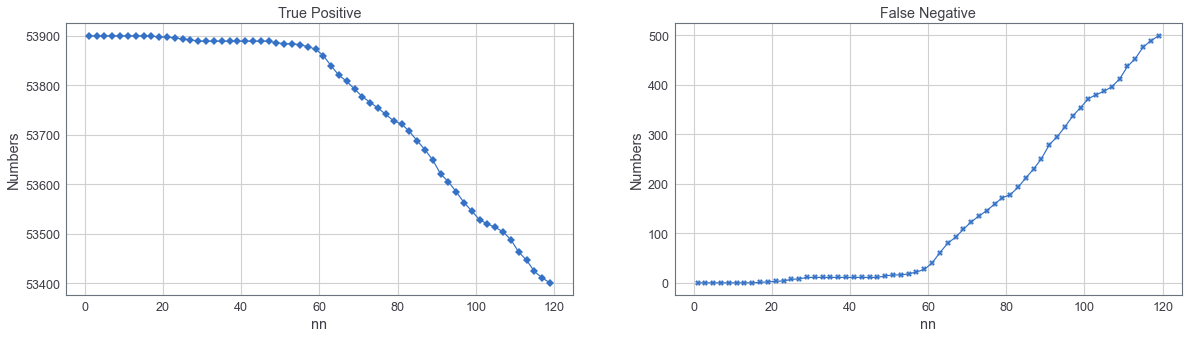

In [129]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(np.arange(1,121, 2), tpr, '-D')
plt.title('True Positive')
plt.xlabel('nn')
plt.ylabel('Numbers')
plt.subplot(122)
plt.plot(np.arange(1,121, 2), fnr, '-X')
plt.title('False Negative')
plt.xlabel('nn')
plt.ylabel('Numbers')
plt.show()

### 2b. Analysis and answers to the questions

## 3. PCA task – 1/2 A4 – Individual

In [49]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_y = testing_label.copy()

### 3a. Plot PCA residuals

In [24]:
# decide n_components
# to normalize the training data
normalizer = Normalizer().fit(train_X)
train_X_norm = normalizer.transform(train_X)

res = []
for n_components in np.arange(5, 25+1):
    # pca
    pca = PCA(n_components=n_components).fit(train_X_norm)

    # pca forward transform
    train_X_pca = pca.transform(train_X_norm)

    # pca backward transform
    train_X_invpca = pca.inverse_transform(train_X_pca)

    # compute residual
    res.append(np.linalg.norm(train_X_norm - train_X_invpca, ord=2, axis=1))
    
    print('>', end='')

>>>>>>>>>>>>>>>>>>>>>

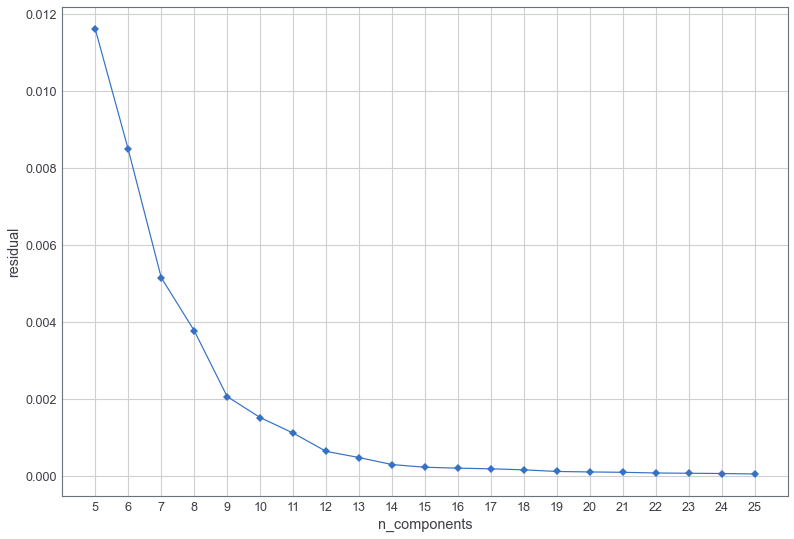

In [33]:
# plot residual ~ n_components
plt.figure(figsize=(13, 9))
plt.plot(np.arange(5, 25+1), np.mean(res, axis=1), '-D')
plt.xticks(ticks=np.arange(5, 25+1))
plt.ylabel('residual')
plt.xlabel('n_components')
plt.show()

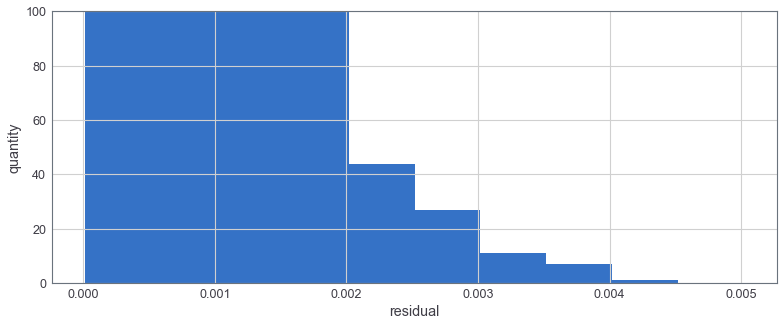

In [90]:
# box-plot to visualize the distribution
plt.figure(figsize=(13, 5))
plt.hist(res[12], range=[np.min(res[12]), np.max(res[12])+0.001])
plt.xlabel('residual')
plt.ylabel('quantity')
plt.ylim([0,100])
plt.show()

In [95]:
n_components = 12
threshold = 0.004

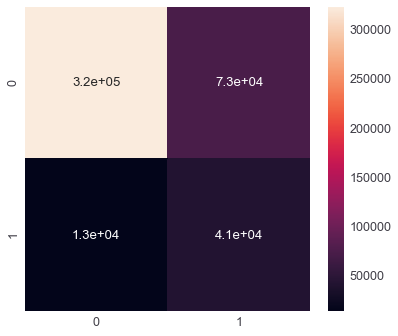

In [96]:
# build pca
pca = PCA(n_components=n_components).fit(train_X_norm)

# normalize testing data
test_X_norm = Normalizer().transform(test_X)

# forward pca
test_X_pca = pca.transform(test_X_norm)

# backward pca
test_X_invpca = pca.inverse_transform(test_X_pca)

# prediction
test_pred = np.linalg.norm(test_X_norm-test_X_invpca, ord=2, axis=1) > threshold

# confusion matrix
cm = confusion_matrix(test_y, test_pred)
f = sns.heatmap(cm, annot=True)

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

In [290]:
train_X = training_signals['AIT504'].copy()
train_y = training_label.copy()
test_X = testing_signals['AIT504'].copy()
test_y = testing_label.copy()

### 4a. Print relevant plots and/or metrics to determine the parameters.

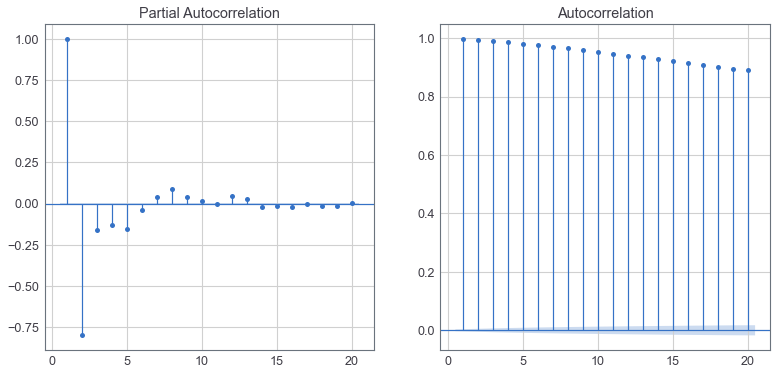

In [291]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_acf(test_X, lags=20, zero=False, ax=ax2)
plot_pacf(train_X, lags=20, zero=False, ax=ax1)
plt.show()

In [293]:
# select the model with lowest aic
aic = np.inf 
order = None
arima = None

p_range = range(1,4) 
q_range = range(1,4) 
d = 0 if (adfuller(train_X[12000:16000])[1] < 0.05) else 1 # stationary

for i in p_range:
    for j in q_range:                  
                temp_model = ARIMA(train_X[12000:16000], order=(i,d,j)).fit()
                temp_aic = temp_model.aic
                if temp_aic < aic:
                    aic = temp_aic
                    order = (i, d, j)
                    arima = temp_model
            

print('Best Order:', best_order)

D:\Programmer\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programmer\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programmer\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best Order: (1, 1, 1)


### 4b. Plots to study the detected anomalies

                               SARIMAX Results                                
Dep. Variable:                 AIT504   No. Observations:               496800
Model:                 ARIMA(1, 1, 1)   Log Likelihood              523827.887
Date:                Sat, 15 May 2021   AIC                       -1047649.775
Time:                        00:07:24   BIC                       -1047616.427
Sample:                             0   HQIC                      -1047640.332
                             - 496800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9027   1.99e-05   4.53e+04      0.000       0.903       0.903
ma.L1         -0.3367   5.12e-05  -6577.634      0.000      -0.337      -0.337
sigma2         0.0071   4.81e-07   1.48e+04      0.0

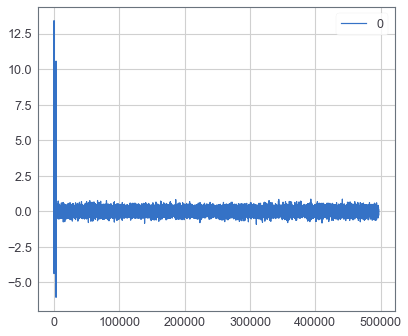

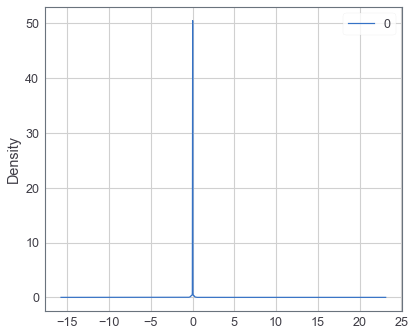

                  0
count  4.968000e+05
mean   2.534855e-05
std    8.620314e-02
min   -6.045064e+00
25%   -2.352428e-09
50%    0.000000e+00
75%    1.767196e-09
max    1.340795e+01


In [294]:
series = train_X
# fit model
model = ARIMA(series, order=best_order)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [295]:
train, test = train_X[10000:20000].values, test_X[11410-250:11410+50].values
label = test_y[11410-250:11410+50]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))

D:\Programmer\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 0.094


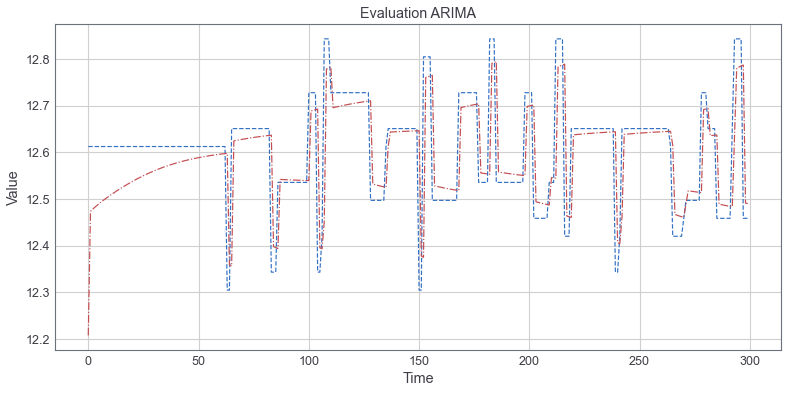

In [296]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(13,6))
plt.plot(test, "--b")
plt.plot(predictions, '-.r')
plt.title("Evaluation ARIMA")
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### 4c. Analysis and answers to the questions

## 5. N-gram task – 1/2 A4 - Individual

### 5a. Visualise discretization

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.